In [1]:
import string
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_recommenders as tfrs
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from ast import literal_eval
from collections import Counter
from typing import Dict, Text
import random

In [2]:
credits = pd.read_csv("movies/credits.csv")
keywords = pd.read_csv("movies/keywords.csv")
movies = pd.read_csv("movies/movies_metadata.csv").drop(['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'status', 'title', 'video'], axis=1).drop([19730, 29503, 35587])
ratings = pd.read_csv("movies/ratings_small.csv")

movies['id'] = movies['id'].astype('int64')

C:\Users\Terry Chong\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [4]:
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [5]:
df = movies.merge(keywords, on='id').merge(credits, on='id')
df

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,keywords,cast,crew
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,7.7,5415.0,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Roll the dice and unleash the excitement!,6.9,2413.0,"[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
3,False,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Friends are the people who let you be yourself...,6.1,34.0,"[{'id': 818, 'name': 'based on novel'}, {'id':...","[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
4,False,0,"[{'id': 35, 'name': 'Comedy'}]",11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Just When His World Is Back To Normal... He's ...,5.7,173.0,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46623,False,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",439050,fa,رگ خواب,Rising and falling between a man and woman.,0.072051,[],"[{'iso_3166_1': 'IR', 'name': 'Iran'}]",NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Rising and falling between a man and woman,4.0,1.0,"[{'id': 10703, 'name': 'tragic love'}]","[{'cast_id': 0, 'character': '', 'credit_id': ...","[{'credit_id': '5894a97d925141426c00818c', 'de..."
46624,False,0,"[{'id': 18, 'name': 'Drama'}]",111109,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,0.178241,"[{'name': 'Sine Olivia', 'id': 19653}]","[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",NaN,9.0,3.0,"[{'id': 2679, 'name': 'artist'}, {'id': 14531,...","[{'cast_id': 1002, 'character': 'Sister Angela...","[{'credit_id': '52fe4af1c3a36847f81e9b15', 'de..."
46625,False,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",67758,en,Betrayal,"When one of her hits goes wrong, a professiona...",0.903007,"[{'name': 'American World Pictures', 'i

In [6]:
df.isnull().sum()

adult                       0
budget                      0
genres                      0
id                          0
original_language          11
original_title              0
overview                  995
popularity                  4
production_companies        4
production_countries        4
release_date               88
revenue                     4
runtime                   268
spoken_languages            4
tagline                 25845
vote_average                4
vote_count                  4
keywords                    0
cast                        0
crew                        0
dtype: int64

In [7]:
df = df.drop('tagline', axis=1)
df = df.dropna()
df

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,vote_average,vote_count,keywords,cast,crew
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",7.7,5415.0,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",6.9,2413.0,"[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",6.5,92.0,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
3,False,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",6.1,34.0,"[{'id': 818, 'name': 'based on novel'}, {'id':...","[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
4,False,0,"[{'id': 35, 'name': 'Comedy'}]",11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",5.7,173.0,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46622,False,0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",30840,en,Robin Hood,"Yet another version of the classic epic, with ...",5.683753,"[{'name': 'Westdeutscher Rundfunk (WDR)', 'id'...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",1991-05-13,0.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",5.7,26.0,[],"[{'cast_id': 1, 'character': 'Sir Robert Hode'...","[{'credit_id': '52fe44439251416c9100a899', 'de..."
46624,False,0,"[{'id': 18, 'name': 'Drama'}]",111109,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,0.178241,"[{'name': 'Sine Olivia', 'id': 19653}]","[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",9.0,3.0,"[{'id': 2679, 'name': 'artist'}, {'id': 14531,...","[{'cast_id': 1002, 'character': 'Sister Angela...","[{'credit_id': '52fe4af1c3a36847f81e9b15', 'de..."
46625,False,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",67758,en,Betrayal,"When one of her hits goes wrong, a professiona...",0.903007,"[{'name': 'American World Pictures', 'id': 6165}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",3.8,6.0,[],"[{'cast_id': 6, 'character': 'Emily Shaw', 'cr...","[{'credit_id': '52fe4

In [8]:
def get_text(text, obj='name'):
    text = literal_eval(text)
    
    if len(text) == 1:
        for i in text:
            return i[obj]
        
    else:
        s = []
        for i in text:
            s.append(i[obj])
        return ', '.join(s)


In [9]:
df['genres'] = df['genres'].apply(get_text)
df['production_companies'] = df['production_companies'].apply(get_text)
df['production_countries'] = df['production_countries'].apply(get_text)
df['spoken_languages'] = df['spoken_languages'].apply(get_text)
df['keywords'] = df['keywords'].apply(get_text)
df['actor'] = df['cast'].apply(get_text)
df['characters'] = df['cast'].apply(get_text, obj='character')
df['crew'] = df['crew'].apply(get_text)
df = df.drop('cast', axis=1)
df['release_date'] = pd.to_datetime(df['release_date'])
df['budget'] = df['budget'].astype('float64')
df['popularity'] = df['popularity'].astype('float64')
df = df.drop_duplicates(subset=['original_title'])
df = df.reset_index(drop=True)

In [10]:
df

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,vote_average,vote_count,keywords,crew,actor,characters
0,False,30000000.0,"Animation, Comedy, Family",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar Animation Studios,United States of America,1995-10-30,373554033.0,81.0,English,7.7,5415.0,"jealousy, toy, boy, friendship, friends, rival...","John Lasseter, Joss Whedon, Andrew Stanton, Jo...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...","Woody (voice), Buzz Lightyear (voice), Mr. Pot..."
1,False,65000000.0,"Adventure, Fantasy, Family",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"TriStar Pictures, Teitler Film, Interscope Com...",United States of America,1995-12-15,262797249.0,104.0,"English, Français",6.9,2413.0,"board game, disappearance, based on children's...","Larry J. Franco, Jonathan Hensleigh, James Hor...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...","Alan Parrish, Samuel Alan Parrish / Van Pelt, ..."
2,False,0.0,"Romance, Comedy",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,"Warner Bros., Lancaster Gate",United States of America,1995-12-22,0.0,101.0,English,6.5,92.0,"fishing, best friend, duringcreditsstinger, ol...","Howard Deutch, Mark Steven Johnson, Mark Steve...","Walter Matthau, Jack Lemmon, Ann-Margret, Soph...","Max Goldman, John Gustafson, Ariel Gustafson, ..."
3,False,16000000.0,"Comedy, Drama, Romance",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,Twentieth Century Fox Film Corporation,United States of America,1995-12-22,81452156.0,127.0,English,6.1,34.0,"based on novel, interracial relationship, sing...","Forest Whitaker, Ronald Bass, Ronald Bass, Ezr...","Whitney Houston, Angela Bassett, Loretta Devin...","Savannah 'Vannah' Jackson, Bernadine 'Bernie' ..."
4,False,0.0,Comedy,11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"Sandollar Productions, Touchstone Pictures",United States of America,1995-02-10,76578911.0,106.0,English,5.7,173.0,"baby, midlife crisis, confidence, aging, daugh...","Alan Silvestri, Elliot Davis, Nancy Meyers, Na...","Steve Martin, Diane Keaton, Martin Short, Kimb...","George Banks, Nina Banks, Franck Eggelhoffer, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42358,False,0.0,Horror,289923,en,The Burkittsville 7,A film archivist revisits the story of Rustin ...,0.386450,"Neptune Salad Entertainment, Pirie Productions",United States of America,2000-10-03,0.0,30.0,English,7.0,1.0,"witch, mythology, legend, serial killer, mocku...","Ben Rock, Ben Rock","Monty Bane, Lucy Butler, David Grammer, Bill D...","Branwall, Sarah Didonna, Kyle Brody, Bill Barn..."
42359,False,0.0,Science Fiction,222848,en,Caged Heat 3000,It's the year 3000 AD. The world's most danger...,0.661558,Concorde-New Horizons,United States of America,1995-01-01,0.0,85.0,English,3.5,1.0,,"Roger Corman, Mike Elliott, Aaron Osborne, Mik...","Lisa Boyle, Kena Land, Zaneta Polard, Don Yana...","Kira (as Cassandra Leigh), Daly, Ruggs, Lewis,..."
42360,False,0.0,Drama,111109,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,0.178241,Sine Olivia,Philippines,2011-11-17,0.0,360.0,,9.0,3.0,"artist, play, pinoy","Lav Diaz, Lav Diaz, Dante Perez, Lav Diaz, Lav...","Angel Aquino, Perry Dizon, Hazel Orencio, Joel...","Sister Angela, Homer, Crazy Woman/Virgin, Aman..."
42361,False,0.0,,227506,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",0.003503,Yermoliev,Russia,1917-10-21,0.0,87.0,,0.0,0.0,,"Yakov Protazanov, Joseph N. Ermolieff","Iwan Mosschuchin, Nathalie Lissenko, Pavel Pav...",", , , ,"


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42363 entries, 0 to 42362
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   adult                 42363 non-null  object        
 1   budget                42363 non-null  float64       
 2   genres                42363 non-null  object        
 3   id                    42363 non-null  int64         
 4   original_language     42363 non-null  object        
 5   original_title        42363 non-null  object        
 6   overview              42363 non-null  object        
 7   popularity            42363 non-null  float64       
 8   production_companies  42363 non-null  object        
 9   production_countries  42363 non-null  object        
 10  release_date          42363 non-null  datetime64[ns]
 11  revenue               42363 non-null  float64       
 12  runtime               42363 non-null  float64       
 13  spoken_languages

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
budget,42363.0,4.191992e+06,1.723974e+07,0.0,0.000000,0.00000,0.000000,3.800000e+08
id,42363.0,1.059049e+05,1.113202e+05,2.0,25647.500000,57701.00000,150027.000000,4.691720e+05
popularity,42363.0,2.943373e+00,5.752899e+00,0.0,0.404918,1.16106,3.784747,5.474883e+02
revenue,42363.0,1.119117e+07,6.377497e+07,0.0,0.000000,0.00000,0.000000,2.787965e+09
runtime,42363.0,9.475918e+01,3.680806e+01,0.0,85.000000,95.00000,107.000000,1.256000e+03
vote_average,42363.0,5.654687e+00,1.890174e+00,0.0,5.000000,6.00000,6.800000,1.000000e+01
vote_count,42363.0,1.100309e+02,4.897686e+02,0.0,3.000000,10.00000,35.000000,1.407500e+04


1. More than 75% of the movies have 0 budget and revenue. We might have to drop these columns since they are not useful to our analysis.
2. Vote are recorded in range [0, 10].
3. Maximum runtime is up to 1256 minutes.

## Correlation Matrix

<AxesSubplot:>

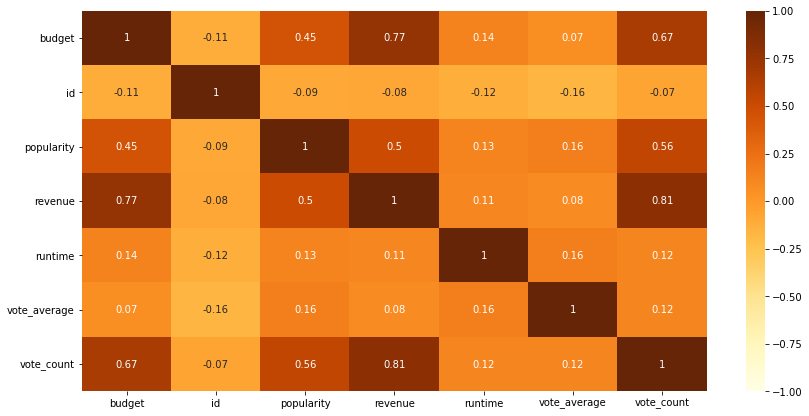

In [13]:
fig, ax = plt.subplots(figsize = (14,7))
corr = df.corr().round(2)
sns.heatmap(corr, annot = True, ax=ax, vmin=-1, vmax=1, center=0, cmap='YlOrBr')

1. We observe a strong relationship between revenue and vote_count.
2. We observe a strong relationship between budget and vote_count.
3. We observe a strong relationship between budget and revenue.

## Univeriate Analysis

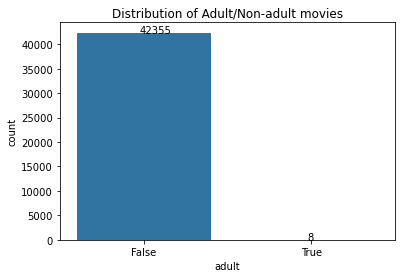

In [14]:
ax = sns.countplot(data=df, x='adult')

for p, label in zip(ax.patches, df['adult'].value_counts()):
    ax.annotate(label, (p.get_x()+0.375, p.get_height()+10))
    ax.set_title("Distribution of Adult/Non-adult movies")

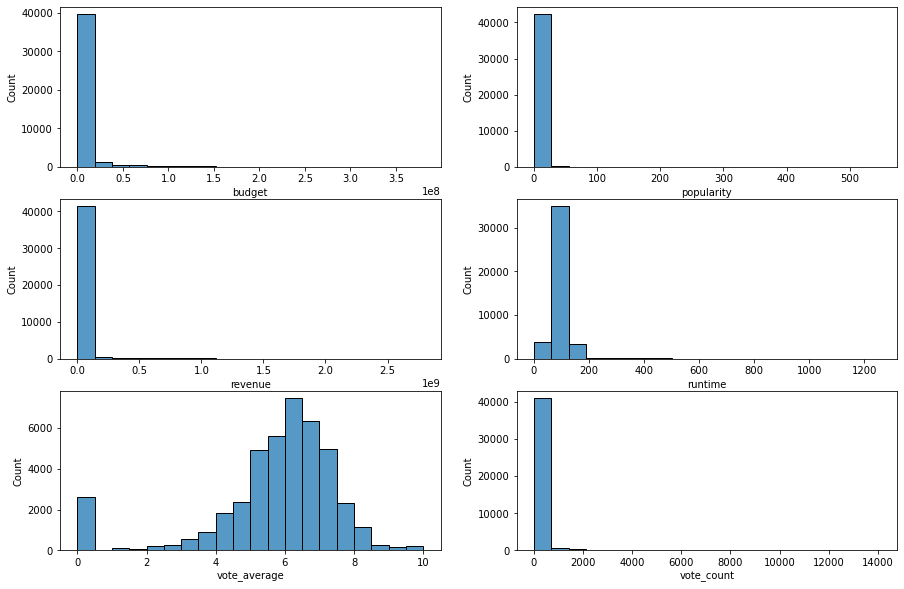

In [15]:
num_col = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']

plt.subplots(3, 2, figsize=(15,10))
# Plot histogram
for col in num_col:
    i = num_col.index(col)
    plt.subplot(3, 2, i+1)
    sns.histplot(data=df,x=col, bins=20)

We observe right skewed for most of the numeric variables

**Most popular movies**

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Minions'),
  Text(1, 0, 'Baby Driver'),
  Text(2, 0, 'Big Hero 6'),
  Text(3, 0, 'Deadpool'),
  Text(4, 0, 'Guardians of the Galaxy Vol. 2'),
  Text(5, 0, 'Avatar'),
  Text(6, 0, 'John Wick'),
  Text(7, 0, 'Gone Girl'),
  Text(8, 0, 'The Hunger Games: Mockingjay - Part 1'),
  Text(9, 0, 'War for the Planet of the Apes')])

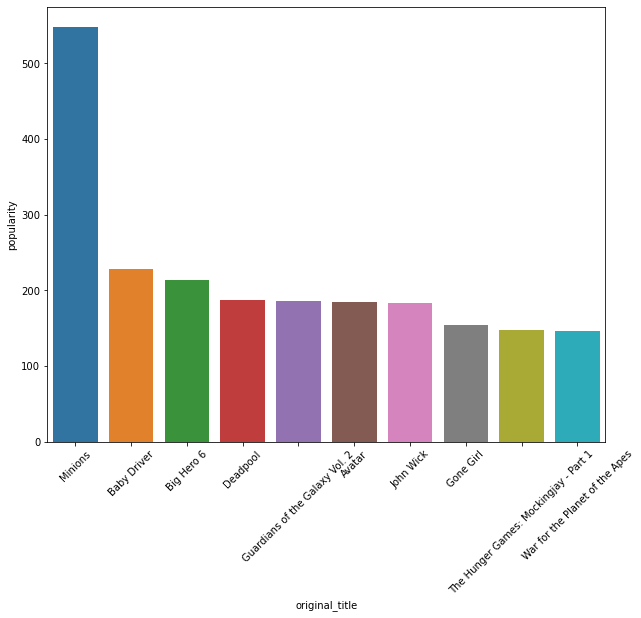

In [16]:
popular = df.sort_values(by='popularity', ascending=False).head(10)

plt.figure(figsize=(10,8))
sns.barplot(data=popular, x= 'original_title', y='popularity')
plt.xticks(rotation=45)

**Most popular genres**

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Drama'),
  Text(1, 0, 'Comedy'),
  Text(2, 0, 'Thriller'),
  Text(3, 0, 'Romance'),
  Text(4, 0, 'Action'),
  Text(5, 0, 'Horror'),
  Text(6, 0, 'Crime'),
  Text(7, 0, 'Documentary'),
  Text(8, 0, 'Adventure'),
  Text(9, 0, 'Science Fiction')])

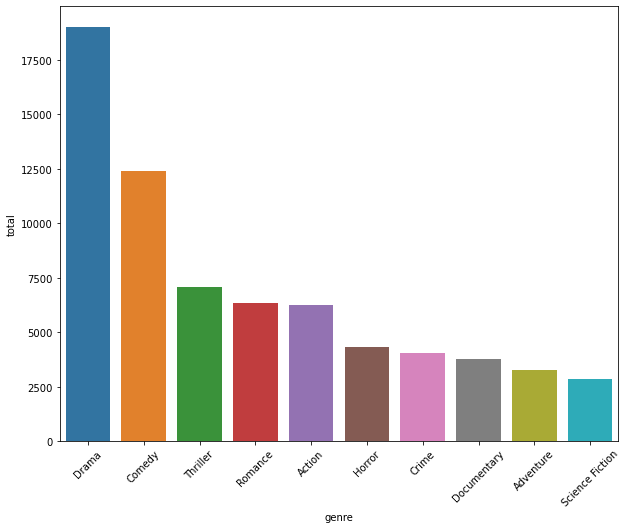

In [17]:
genres_list = []
for i in df['genres']:
    genres_list.extend(i.split(', '))

genres = pd.DataFrame(Counter(genres_list).most_common(10), columns=['genre', 'total'])

plt.figure(figsize=(10,8))
sns.barplot(data=genres, x='genre', y='total')
plt.xticks(rotation=45)

**Most popular actors**

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Bess Flowers'),
  Text(1, 0, 'Christopher Lee'),
  Text(2, 0, 'John Wayne'),
  Text(3, 0, 'Samuel L. Jackson'),
  Text(4, 0, 'Jackie Chan'),
  Text(5, 0, 'Gérard Depardieu'),
  Text(6, 0, 'Frank Welker'),
  Text(7, 0, 'John Carradine'),
  Text(8, 0, 'Donald Sutherland'),
  Text(9, 0, 'Robert De Niro')])

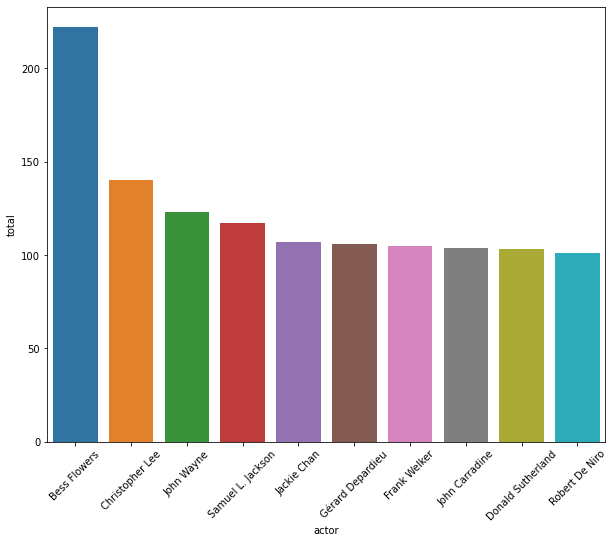

In [18]:
actors_list = []
for i in df['actor']:
    actors_list.extend(i.split(', '))

actors_list = [x for x in actors_list if not x == 'Jr.' and not x == '']

    
actors = pd.DataFrame(Counter(actors_list).most_common(10), columns=['actor', 'total'])

plt.figure(figsize=(10,8))
sns.barplot(data=actors, x='actor', y='total')
plt.xticks(rotation=45)

**Most popular characters in movies**

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Doctor'),
  Text(1, 0, 'Dancer'),
  Text(2, 0, 'himself'),
  Text(3, 0, 'Narrator'),
  Text(4, 0, 'Reporter'),
  Text(5, 0, 'Nurse'),
  Text(6, 0, '(uncredited)'),
  Text(7, 0, 'Anna'),
  Text(8, 0, 'Paul'),
  Text(9, 0, 'Sam')])

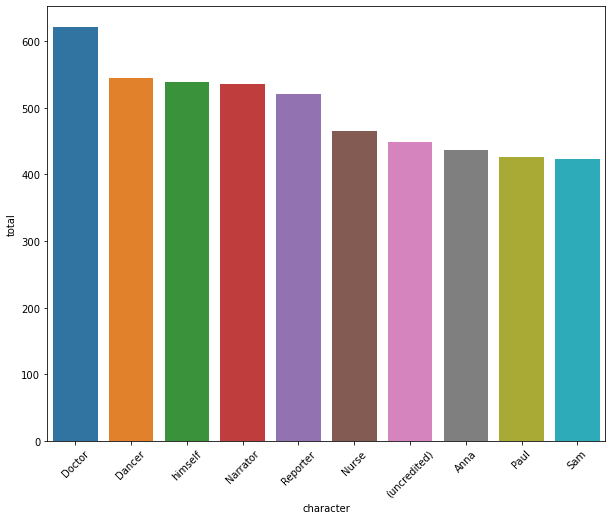

In [19]:
characters_list = []
for i in df['characters']:
    characters_list.extend(i.split(', '))

characters_list = [x for x in characters_list if not x == '' and not x == 'Himself' and not x == 'Herself']

    
characters = pd.DataFrame(Counter(characters_list).most_common(10), columns=['character', 'total'])

plt.figure(figsize=(10,8))
sns.barplot(data=characters, x='character', y='total')
plt.xticks(rotation=45)

**Most popular keywords in movies**

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'woman director'),
  Text(1, 0, 'independent film'),
  Text(2, 0, 'murder'),
  Text(3, 0, 'based on novel'),
  Text(4, 0, 'musical'),
  Text(5, 0, 'sex'),
  Text(6, 0, 'violence'),
  Text(7, 0, 'nudity'),
  Text(8, 0, 'biography'),
  Text(9, 0, 'revenge')])

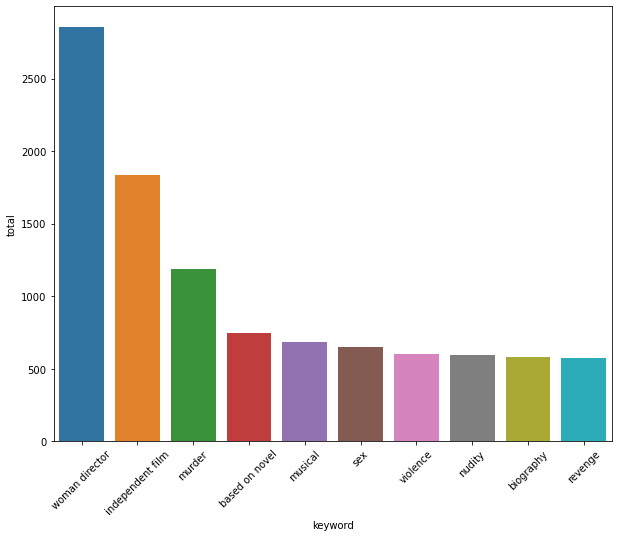

In [20]:
keywords_list = []
for i in df['keywords']:
    keywords_list.extend(i.split(', '))

keywords_list = [x for x in keywords_list if not x == '']

    
keywords = pd.DataFrame(Counter(keywords_list).most_common(10), columns=['keyword', 'total'])

plt.figure(figsize=(10,8))
sns.barplot(data=keywords, x='keyword', y='total')
plt.xticks(rotation=45)

**Most popular movie production companies**

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Warner Bros.'),
  Text(1, 0, 'Metro-Goldwyn-Mayer (MGM)'),
  Text(2, 0, 'Paramount Pictures'),
  Text(3, 0, 'Universal Pictures'),
  Text(4, 0, 'Twentieth Century Fox Film Corporation'),
  Text(5, 0, 'Columbia Pictures Corporation'),
  Text(6, 0, 'Canal+'),
  Text(7, 0, 'Columbia Pictures'),
  Text(8, 0, 'RKO Radio Pictures'),
  Text(9, 0, 'United Artists')])

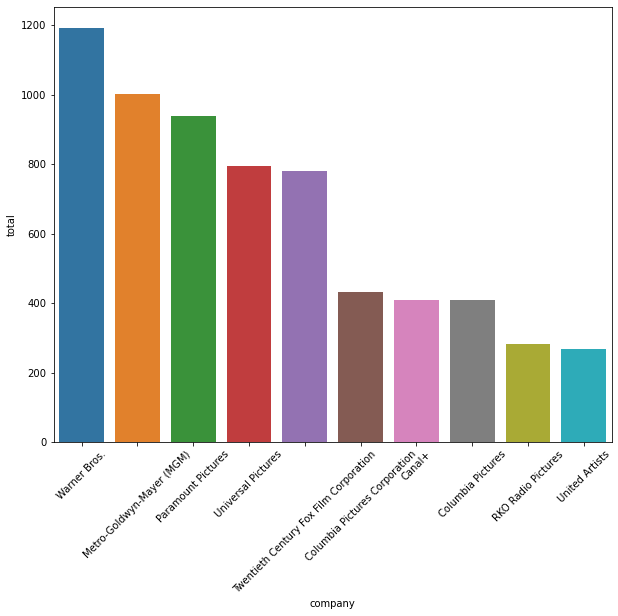

In [21]:
companies_list = []
for i in df['production_companies']:
    companies_list.extend(i.split(', '))

companies_list = [x for x in companies_list if not x == '']

    
companies = pd.DataFrame(Counter(companies_list).most_common(10), columns=['company', 'total'])

plt.figure(figsize=(10,8))
sns.barplot(data=companies, x='company', y='total')
plt.xticks(rotation=45)

Text(0.5, 1.0, 'Total Released Movies by Date')

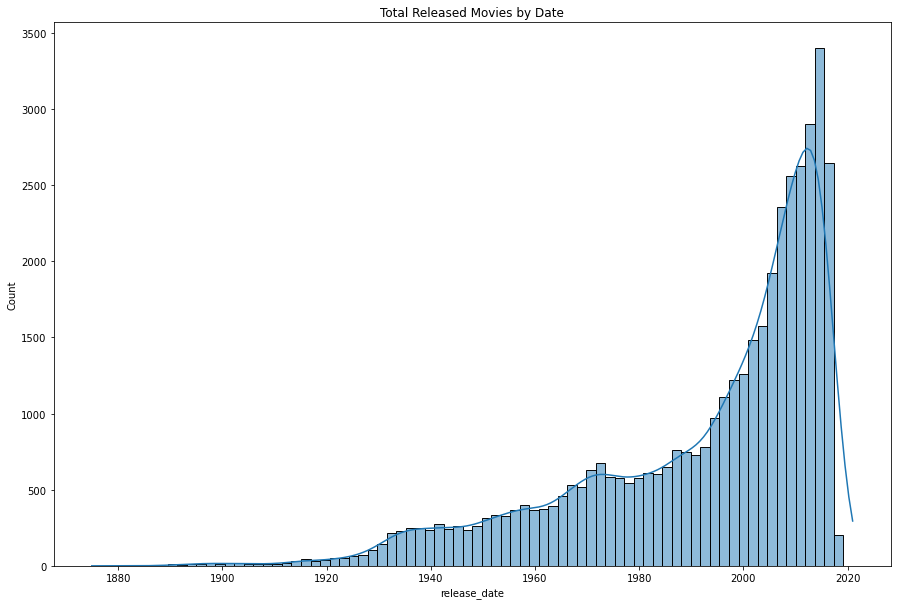

In [22]:
plt.figure(figsize=(15,10))
ax = sns.histplot(data=df, x='release_date', kde='True')
plt.title('Total Released Movies by Date')

## Bivariate Analysis

Text(0.5, 1.0, 'Relationship between revenues and budgets for movies')

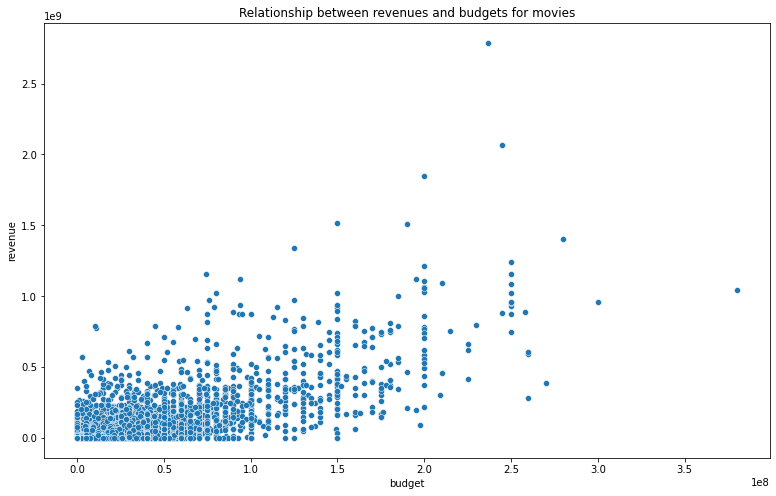

In [23]:
plt.figure(figsize=(13,8))
sns.scatterplot(data=df, x='budget', y='revenue')
plt.title('Relationship between revenues and budgets for movies')

Text(0.5, 1.0, 'Relationship between revenues, budgets, and vote counts for movies')

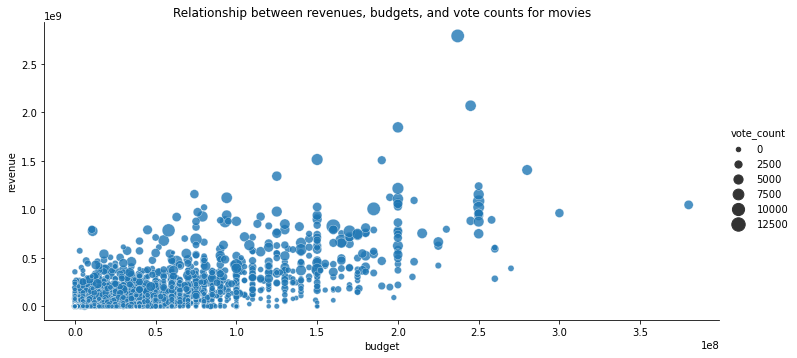

In [24]:
#plt.figure(figsize=(13,8))
sns.relplot(data=df, x='budget', y='revenue', size='vote_count', sizes=(20,200), alpha=0.8, aspect=2)
plt.title('Relationship between revenues, budgets, and vote counts for movies')

Text(0.5, 1.0, 'Relationship between budgets and vote_counts for movies')

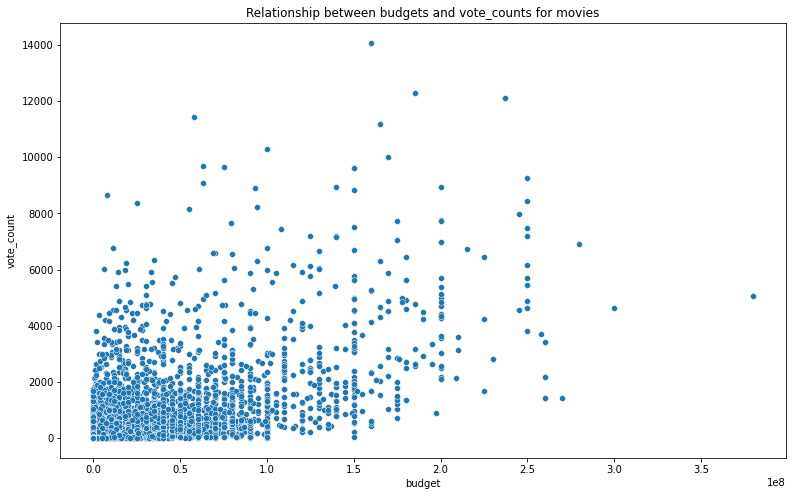

In [25]:
plt.figure(figsize=(13,8))
sns.scatterplot(data=df, x='budget', y='vote_count')
plt.title('Relationship between budgets and vote_counts for movies')

Text(0.5, 1.0, 'Relationship between revenues and vote_counts for movies')

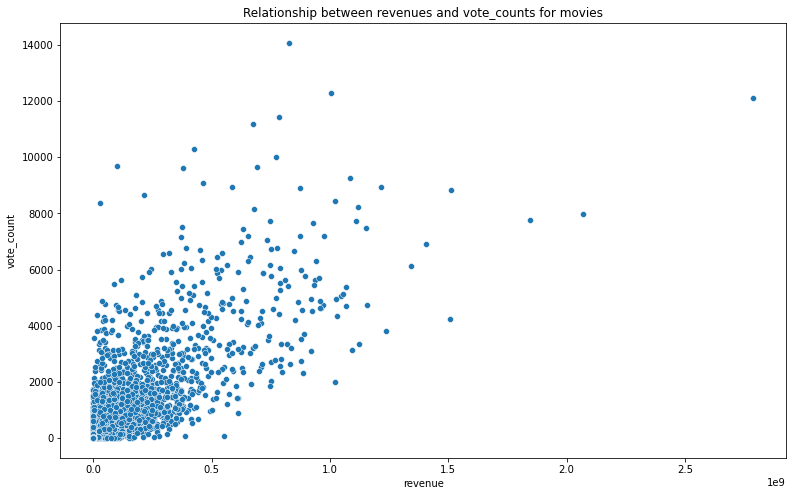

In [26]:
plt.figure(figsize=(13,8))
sns.scatterplot(data=df, x='revenue', y='vote_count')
plt.title('Relationship between revenues and vote_counts for movies')

Text(0.5, 1.0, 'Relationship between runtime and popularity for movies')

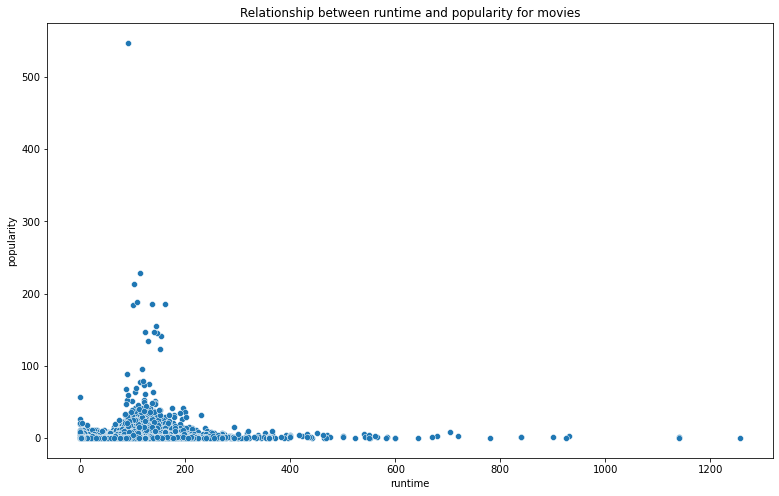

In [27]:
plt.figure(figsize=(13,8))
sns.scatterplot(data=df, x='runtime', y='popularity')
plt.title('Relationship between runtime and popularity for movies')

It looks like the more popular movies sit around 150-200 minutes runtime

Text(0.5, 1.0, 'Relationship between revenues and budgets for movies')

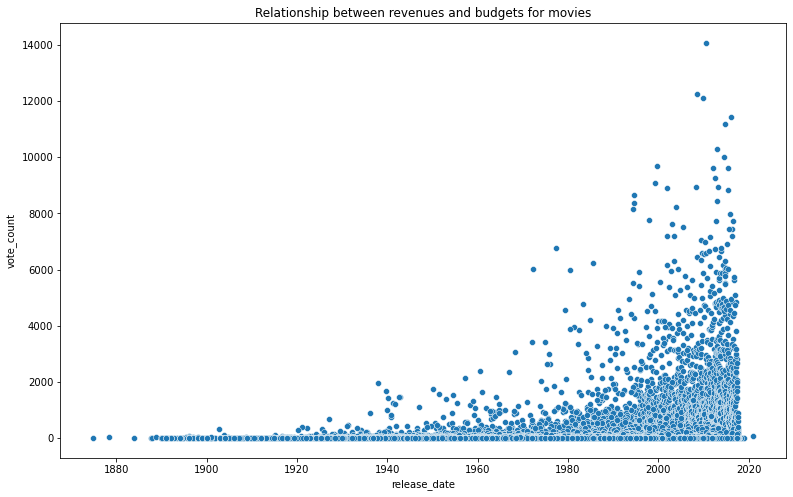

In [28]:
plt.figure(figsize=(13,8))
sns.scatterplot(data=df, x='release_date', y='vote_count')
plt.title('Relationship between revenues and budgets for movies')

There are more vote counts for recent released movies. These are normal because more users are using internet and the movie rating system online.

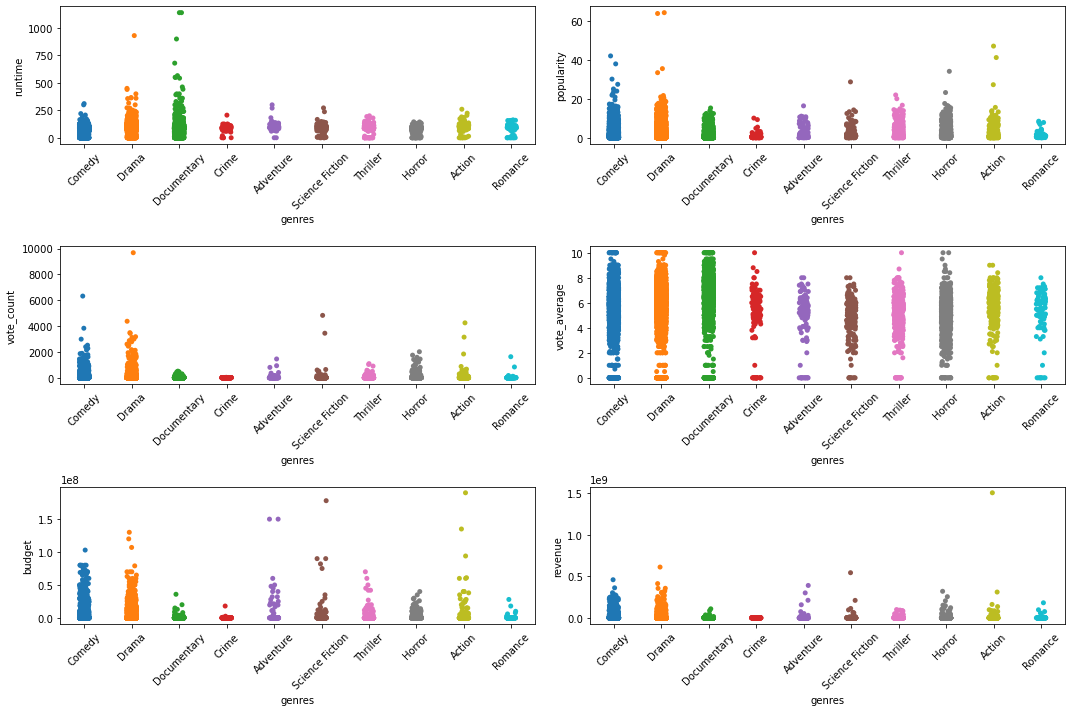

In [29]:
genres = pd.DataFrame(Counter(genres_list).most_common(10), columns=['genre', 'total'])
genres = df[df['genres'].isin(genres['genre'].to_numpy())]

fig, ax = plt.subplots(3, 2, figsize=(15, 10))

for i , y in enumerate(['runtime', 'popularity', 'vote_count', 'vote_average', 'budget', 'revenue']):

    sns.stripplot(data=genres, x='genres', y=y, ax=ax.flatten()[i])

    for tick in ax.flatten()[i].get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()

1. Documentary has longer runtime, but with lower vote_count and lower budget and revenue.
2. Overall, we can see Comedy and Drama are the genres that are more welcomed for audience.
3. One action movie generated very high revenue.

In [30]:
df[df.revenue == df.revenue.max()]

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,vote_average,vote_count,keywords,crew,actor,characters
14067,False,237000000.0,"Action, Adventure, Fantasy, Science Fiction",19995,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",185.070892,"Ingenious Film Partners, Twentieth Century Fox...","United States of America, United Kingdom",2009-12-10,2.787965e+09,162.0,"English, Español",7.2,12114.0,"culture clash, future, space war, space colony...","Stephen E. Rivkin, Rick Carter, Christopher Bo...","Sam Worthington, Zoe Saldana, Sigourney Weaver...","Jake Sully, Princess Neytiri, Dr. Grace August..."


It's Avatar!

## Recommender System

In [31]:
# Preprocess ratings dataFrame
ratings

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [32]:
ratings['date'] = ratings['timestamp'].apply(lambda x: pd.datetime.fromtimestamp(x))
ratings.drop('timestamp', axis=1, inplace=True)

ratings

<ipython-input-32-24a0f0b7e350>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ratings['date'] = ratings['timestamp'].apply(lambda x: pd.datetime.fromtimestamp(x))


,userId,movieId,rating,date
0,1,31,2.5,2009-12-13 20:52:24
1,1,1029,3.0,2009-12-13 20:52:59
2,1,1061,3.0,2009-12-13 20:53:02
3,1,1129,2.0,2009-12-13 20:53:05
4,1,1172,4.0,2009-12-13 20:53:25
...,...,...,...,...
99999,671,6268,2.5,2003-10-07 21:16:10
100000,671,6269,4.0,2003-10-02 21:46:41
100001,671,6365,4.0,2003-12-08 21:26:03
100002,671,6385,2.5,2003-12-09 08:21:03


In [33]:
ratings = ratings.merge(df[['id', 'original_title', 'genres', 'overview']], left_on='movieId', right_on='id', how='left')
ratings = ratings.dropna().reset_index(drop=True)
ratings['userId'] = ratings['userId'].astype(str)
ratings1 = ratings

print(ratings.shape)
ratings.head()

(43188, 8)


,userId,movieId,rating,date,id,original_title,genres,overview
0,1,1371,2.5,2009-12-13 20:52:15,1371.0,Rocky III,Drama,"Now the world champion, Rocky Balboa is living..."
1,1,1405,1.0,2009-12-13 20:53:23,1405.0,Greed,"Drama, History",Greed is the classic 1924 silent film by Erich...
2,1,2105,4.0,2009-12-13 20:52:19,2105.0,American Pie,"Comedy, Romance","At a high-school party, four friends find that..."
3,1,2193,2.0,2009-12-13 20:53:18,2193.0,My Tutor,"Comedy, Drama, Romance",High school senior Bobby Chrystal fails his Fr...
4,1,2294,2.0,2009-12-13 20:51:48,2294.0,Jay and Silent Bob Strike Back,Comedy,When Jay and Silent Bob learn that their comic...


In [34]:
movies = df[['id', 'original_title']].rename(columns={'id': 'movieId'})

print(movies.shape)
movies.head()

(42363, 2)


,movieId,original_title
0,862,Toy Story
1,8844,Jumanji
2,15602,Grumpier Old Men
3,31357,Waiting to Exhale
4,11862,Father of the Bride Part II


In [35]:
ratings = tf.data.Dataset.from_tensor_slices(dict(ratings[['userId', 'original_title', 'rating']]))
movies = tf.data.Dataset.from_tensor_slices(dict(movies[['original_title']]))

ratings = ratings.map(lambda x: {
    "original_title": x["original_title"],
    "userId": x["userId"],
    "rating": float(x["rating"])
})

movies = movies.map(lambda x: x["original_title"])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [36]:
print('Total Data: {}'.format(len(ratings)))

tf.random.set_seed(42)
shuffled = ratings.shuffle(len(ratings), seed=42, reshuffle_each_iteration=False)

train = shuffled.take(int(len(ratings)*0.8))
test = shuffled.skip(int(len(ratings)*0.8)).take(int(len(ratings)*0.2))

cached_train = train.shuffle(len(ratings)).batch(1024)
cached_test = test.batch(1024).cache()

Total Data: 43188


In [37]:
user_ids_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
user_ids_vocabulary.adapt(ratings.map(lambda x: x["userId"]))

movie_titles_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
movie_titles_vocabulary.adapt(movies)

In [38]:
class MovieLensModel(tfrs.Model):
    def __init__(
            self,
            user_model: tf.keras.Model,
            movie_model: tf.keras.Model,
            rating_task: tfrs.tasks.Ranking,
            retrieval_task: tfrs.tasks.Retrieval):
        super().__init__()
        
        # Set up user and movie representations.
        self.user_model = user_model
        self.movie_model = movie_model
        self.rating_model = rating_model
        
        # Set up tasks.
        self.rating_task = rating_task
        self.retrieval_task = retrieval_task
    
    def call(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor: 
        user_embeddings = self.user_model(features['userId'])
        movie_embeddings = self.movie_model(features['original_title'])
        
        return(user_embeddings, movie_embeddings, self.rating_model(tf.concat([user_embeddings, movie_embeddings], axis=1)))
    
    
    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor: 
        #Define how the loss is computed
        
        ratings = features.pop("rating")
        
        user_embeddings, movie_embeddings, rating_predictions = self(features)
        
        rating_loss = self.rating_task(labels=ratings, predictions=rating_predictions)
        retrieval_loss = self.retrieval_task(user_embeddings, movie_embeddings)
        
        return (rating_loss + retrieval_loss)
        
        

In [39]:
# Define user and movie models.
user_model = tf.keras.Sequential([
    user_ids_vocabulary,
    tf.keras.layers.Embedding(user_ids_vocabulary.vocabulary_size(), 64)
])

movie_model = tf.keras.Sequential([
    movie_titles_vocabulary,
    tf.keras.layers.Embedding(movie_titles_vocabulary.vocabulary_size(), 64)
])

# Define rating model
rating_model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1),
])

# Define your objectives.
retrieval_task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
    movies.batch(128).map(movie_model)
    )
)

rating_task = tfrs.tasks.Ranking(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)

In [40]:
# Create a retrieval model
model = MovieLensModel(user_model, movie_model, rating_task, retrieval_task)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001))

# Train for 3 epochs.
model.fit(cached_train, epochs=10)

Epoch 1/10
34/34 [==============================] - 79s 2s/step - root_mean_squared_error: 2.9427 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 5.7887e-05 - factorized_top_k/top_10_categorical_accuracy: 1.7366e-04 - factorized_top_k/top_50_categorical_accuracy: 0.0010 - factorized_top_k/top_100_categorical_accuracy: 0.0023 - loss: 6988.0417 - regularization_loss: 0.0000e+00 - total_loss: 6988.0417
Epoch 2/10
34/34 [==============================] - 84s 2s/step - root_mean_squared_error: 1.1233 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0016 - factorized_top_k/top_10_categorical_accuracy: 0.0031 - factorized_top_k/top_50_categorical_accuracy: 0.0112 - factorized_top_k/top_100_categorical_accuracy: 0.0188 - loss: 6976.9495 - regularization_loss: 0.0000e+00 - total_loss: 6976.9495
Epoch 3/10
34/34 [==============================] - 88s 3s/step - root_mean_squared_erro

In [41]:
model.evaluate(cached_test)

9/9 [==============================] - 28s 3s/step - root_mean_squared_error: 0.9259 - factorized_top_k/top_1_categorical_accuracy: 0.0028 - factorized_top_k/top_5_categorical_accuracy: 0.0161 - factorized_top_k/top_10_categorical_accuracy: 0.0352 - factorized_top_k/top_50_categorical_accuracy: 0.1628 - factorized_top_k/top_100_categorical_accuracy: 0.2521 - loss: 6047.8838 - regularization_loss: 0.0000e+00 - total_loss: 6047.8838


[0.9258769750595093,
 0.0027787426952272654,
 0.016093550249934196,
 0.03519740700721741,
 0.1627880036830902,
 0.2520551085472107,
 2637.403564453125,
 0,
 2637.403564453125]

In [42]:
def predict_movie(userId, top_n):
    # Use brute-force search to set up retrieval using the trained representations.
    index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
    index.index_from_dataset(
        movies.batch(100).map(lambda title: (title, model.movie_model(title))))
    
    # Get some recommendations
    _, titles = index(np.array([str(userId)]))
    
    print("Top {} recommendations for user {}: \n".format(top_n, userId))
    for i, title in enumerate(titles[0, :top_n].numpy()):
        print('{}. {}'.format(i+1, title.decode("utf-8")))

def predict_rating(userId, movie):
    trained_movie_embeddings, trained_user_embeddings, predicted_rating = model({
        "userId": np.array([str(userId)]),
        "original_title": np.array([movie])
    })
    
    #return predicted_rating
    print("Predicted rating for user {} for movie {}: {}".format(userId, movie, predicted_rating.numpy()[0][0]))
    
def predict_movie_df(userId, top_n):
    # Use brute-force search to set up retrieval using the trained representations.
    index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
    index.index_from_dataset(
        movies.batch(100).map(lambda title: (title, model.movie_model(title))))
    
    # Get some recommendations
    _, titles = index(np.array([str(userId)]))
    
    title_list = []
    for i, title in enumerate(titles[0, :top_n].numpy()):
        title_list.append(title.decode("utf-8"))
        
    # Predicted ratings
    rating_list = []
    for movie in title_list:
        trained_movie_embeddings, trained_user_embeddings, predicted_rating = model({
        "userId": np.array([str(userId)]),
        "original_title": np.array([movie])
        })
        rating_list.append(predicted_rating.numpy()[0][0])
        
    temp = pd.DataFrame({'original_title': title_list, 'predicted_rating': rating_list})
   
    # Create dataFrame
    predicted_movie_df = df[df['original_title'].isin(title_list)]
    predicted_movie_df = predicted_movie_df[['id', 'original_title', 'genres', 'overview']]
    predicted_movie_df = predicted_movie_df.merge(temp, on='original_title')
    predicted_movie_df = predicted_movie_df.reset_index(drop=True)
    
    return predicted_movie_df

In [43]:
user_list = ratings1.userId.unique()
user = random.choice(user_list)

movie_list = df.original_title.unique()
movie = random.choice(movie_list)

In [44]:
predict_movie(user, 5)

Top 5 recommendations for user 433: 

1. Confession of a Child of the Century
2. 5 Card Stud
3. Bad Boys II
4. Longitude
5. The Great American Girl Robbery


In [45]:
predict_rating(user, movie)

Predicted rating for user 433 for movie Men of Means: 3.034231662750244


## Examining User Input and Prediction 

**User 1**

In [46]:
user_input = ratings1[ratings1.userId == str(user)]
user_input = user_input[['userId', 'movieId', 'original_title', 'genres', 'overview', 'rating']]
user_input

,userId,movieId,original_title,genres,overview,rating
26028,433,6,Judgment Night,"Action, Thriller, Crime","While racing to a boxing match, Frank, Mike, J...",5.0
26029,433,11,Star Wars,"Adventure, Action, Science Fiction",Princess Leia is captured and held hostage by ...,1.5
26030,433,16,Dancer in the Dark,"Drama, Crime, Music","Selma, a Czech immigrant on the verge of blind...",4.5
26031,433,19,Metropolis,"Drama, Science Fiction",In a futuristic city sharply divided between t...,2.5
26032,433,104,Lola rennt,"Action, Drama, Thriller",Lola receives a phone call from her boyfriend ...,3.0
...,...,...,...,...,...,...
26101,433,54503,Shuang ma lian huan,"Action, Foreign",Lee Yi Min stars as an eager young kung fu stu...,5.0
26102,433,58559,Confession of a Child of the Century,Drama,"Paris, 1830: Octave, betrayed by his mistress,...",4.5
26103,433,65188,Leben nach Microsoft,Documentary,Der Film portraitiert eine Gruppe von Microsof...,4.5
26104,433,68954,Longitude,"TV Movie, Drama, History",Parallel stories: 18th century Harrison builds...,3.0


In [47]:
predict_movie_df(user, 5)

,id,original_title,genres,overview,predicted_rating
0,4993,5 Card Stud,"Action, Western, Thriller",The players in an ongoing poker game are being...,4.463721
1,8961,Bad Boys II,"Adventure, Action, Comedy, Thriller, Crime","Out-of-control, trash-talking buddy cops Marcu...",4.143842
2,46578,The Great American Girl Robbery,"Comedy, Crime",A busload containing three cheerleading teams ...,4.099746
3,58559,Confession of a Child of the Century,Drama,"Paris, 1830: Octave, betrayed by his mistress,...",4.518332
4,68954,Longitude,"TV Movie, Drama, History",Parallel stories: 18th century Harrison builds...,4.306906


**User 2**

In [48]:
user_list = ratings1.userId.unique()
user2 = random.choice(user_list)

user2_input = ratings1[ratings1.userId == str(user2)]
user2_input = user2_input[['userId', 'movieId', 'original_title', 'genres', 'overview', 'rating']]
user2_input

,userId,movieId,original_title,genres,overview,rating
28396,466,2,Ariel,"Drama, Crime",Taisto Kasurinen is a Finnish coal miner whose...,3.0
28397,466,25,Jarhead,"Drama, War",Jarhead is a film about a US Marine Anthony Sw...,3.0
28398,466,150,48 Hrs.,"Thriller, Action, Comedy, Crime, Drama",A hard-nosed cop reluctantly teams up with a w...,4.0
28399,466,153,Lost in Translation,Drama,"Two lost souls visiting Tokyo -- the young, ne...",2.0
28400,466,223,Rebecca,"Drama, Mystery",A self-conscious bride is tormented by the mem...,5.0
...,...,...,...,...,...,...
28517,466,3097,"The Tulse Luper Suitcases, Part 1: The Moab Story","War, Drama, History, Adventure, Romance, Thriller",The Tulse Luper Suitcases reconstructs the lif...,4.0
28518,466,3114,The Searchers,Western,As a Civil War veteran spends years searching ...,5.0
28519,466,3175,Barry Lyndon,"Drama, Romance, War","In the Eighteenth Century, in a small village ...",2.0
28520,466,3176,バトル・ロワイアル,"Drama, Thriller, Adventure","In the future, the Japanese government capture...",4.0


In [49]:
predict_movie_df(user2, 5)

,id,original_title,genres,overview,predicted_rating
0,2087,The Getaway,"Drama, Action, Thriller",Doc McCoy is put in prison because his partner...,4.082183
1,2088,Romeo Is Bleeding,"Action, Crime, Drama, Thriller",A corrupt cop gets in over his head when he tr...,3.325758
2,2469,¡Átame!,"Comedy, Crime, Drama, Romance","Recently released from a mental hospital, Rick...",3.273397
3,898,Birdman of Alcatraz,Drama,"After killing a prison guard, convict Robert S...",4.407057
4,1947,An Unfinished Life,Drama,"Stoic and heartbroken, Einar Gilkyson quietly ...",4.228199


**User 3**

In [50]:
user_list = ratings1.userId.unique()
user3 = random.choice(user_list)

user3_input = ratings1[ratings1.userId == str(user3)]
user3_input = user3_input[['userId', 'movieId', 'original_title', 'genres', 'overview', 'rating']]
user3_input

,userId,movieId,original_title,genres,overview,rating
3138,48,2,Ariel,"Drama, Crime",Taisto Kasurinen is a Finnish coal miner whose...,3.5
3139,48,110,Trois couleurs : Rouge,"Drama, Mystery, Romance",Red This is the third film from the trilogy by...,4.0
3140,48,111,Scarface,"Action, Crime, Drama, Thriller",After getting a green card in exchange for ass...,3.0
3141,48,158,Knockin' on Heaven's Door,"Comedy, Crime","Two young men, Martin and Rudi, both suffering...",3.0
3142,48,163,Ocean's Twelve,"Thriller, Crime",Danny Ocean reunites with his old flame and th...,3.5
...,...,...,...,...,...,...
3282,48,103688,Daydream Believers: The Monkees Story,"Drama, Music, Documentary","In 2000, VH-1 produced the television biopic D...",3.0
3283,48,107406,Oscenità,Drama,Banned for few years in Italy due to its trans...,2.5
3284,48,110501,Sedam i po,"Comedy, Foreign, Drama",Sedam I Po is a Serbian movie. Seven stories f...,3.0
3285,48,110553,Austin High,Comedy,What would happen if a group of high school sl...,3.0


In [51]:
predict_movie_df(user3, 5)

,id,original_title,genres,overview,predicted_rating
0,46578,The Great American Girl Robbery,"Comedy, Crime",A busload containing three cheerleading teams ...,3.915922
1,88744,Die Frau mit den 5 Elefanten,"Documentary, Foreign","Documentary about Svetlana Geier, a Ukranian w...",3.905870
2,58559,Confession of a Child of the Century,Drama,"Paris, 1830: Octave, betrayed by his mistress,...",4.381993
3,48780,Boat,Foreign,A journey into night.,4.176009
4,68954,Longitude,"TV Movie, Drama, History",Parallel stories: 18th century Harrison builds...,4.208941


## Collaborative Filtering

In [52]:
cf = ratings1[['userId', 'movieId', 'rating']]
movie_rating_more_than_ten = cf.groupby("movieId").filter(lambda x: x['rating'].count() >= 10)

In [53]:
ratings_matrix = movie_rating_more_than_ten.pivot_table(values='rating', index='userId', columns='movieId', fill_value=0)
ratings_matrix

movieId,2,3,5,6,11,12,14,15,16,17,...,85414,86332,88744,89492,93840,94959,96821,97938,104374,111759
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,5.0,4.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0


In [54]:
X = ratings_matrix.transpose()
X.tail()

userId,1,10,100,101,102,103,104,105,106,107,...,90,91,92,93,94,95,96,97,98,99
movieId,,,,,,,,,,,,,,,,,,,,,
94959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0
96821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104374,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
cosine_matrix = cosine_similarity(X)
cosine_matrix.shape

(913, 913)

In [56]:
def recommend_cosine(i):
    original_title = list(X.index)
    movieId = original_title.index(i)
    cosine_movieId = cosine_matrix[movieId]
    Recommend = pd.DataFrame({"movieId": X.index, "cosine_similarity": cosine_movieId})
    Recommend = Recommend.sort_values(by="cosine_similarity", ascending=False)
    Recommend = Recommend.drop(index=movieId)
    Recommend = Recommend.iloc[:10,:]
    Recommend = Recommend.reset_index(drop=True)
    temp = df[df['id'].isin(Recommend.movieId)]
    temp = temp[['id', 'original_title', 'genres', 'overview']]
    Recommend = Recommend.merge(temp, left_on="movieId", right_on="id", how="left")
    Recommend = Recommend.drop('id', axis=1)
    return Recommend

In [57]:
recommend_cosine(2)

,movieId,cosine_similarity,original_title,genres,overview
0,500,0.546348,Reservoir Dogs,"Crime, Thriller",A botched robbery indicates a police informant...
1,364,0.530357,Batman Returns,"Action, Fantasy","Having defeated the Joker, Batman now faces th..."
2,317,0.505831,Grbavica,"Drama, History",A woman and her daughter struggle to make thei...
3,595,0.494124,To Kill a Mockingbird,"Crime, Drama","In a small Alabama town in the 1930s, scrupulo..."
4,588,0.493995,Silent Hill,"Horror, Mystery",The eerie and deserted ghost town of Silent Hi...
5,344,0.475673,Bang Boom Bang - Ein todsicheres Ding,"Crime, Action, Comedy",Bank robber Kelle Grabowski escapes from priso...
6,587,0.474787,Big Fish,"Adventure, Fantasy, Drama",Throughout his life Edward Bloom has always be...
7,480,0.471624,Monsoon Wedding,"Comedy, Drama, Romance",From an exciting Indian wedding comes a relati...
8,377,0.470265,A Nightmare on Elm Street,Horror,Teenagers in a small town are dropping like fl...
9,586,0.466820,Wag the Dog,"Comedy, Drama","During the final weeks of a presidential race,..."


## Conclusion

In this Notebook, we explored two ways to perform recommendation to customers. First, we built recommender using **tensorflow recommender system (TFRS)**. TFRS is a library for building recommender system models. The advantages of using TFRS are:
1. Build and evaluate flexible recommendation retrieval models.
2. Freely incorporate item, user, and context information into recommendation models.
3. Train multi-task models that jointly optimize multiple recommendation objectives.

Second, we built recommender using **Collaborative-filtering**. Collaborative-filtering uses similarities between users and items simultaneously to provide recommendations. Collaborative filtering models can recommend an item to user A based on the interests of a similar user B. Furthermore, the embeddings can be learned automatically, without relying on hand-engineering of features.

## Addtional Steps

There more future works can be done with this notebook:
1. Explore deeper model for TFRS
2. Explore collaborative-filtering model with more than one user input